In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize, differential_evolution

## 3.6 - Numerical Computation of VIX Futures Prices

In [22]:
def vix_future_price(
        tau,
        v_t,
        lambda_,
        theta,
        xi,
        eta=30/252,
    ):
    """
    fVIX pricing formula 

    Parameters
    ----------
    tau      : float > 0
    v_t      : float > 0
    lambda_  : mean reversion speed  (λ)
    theta    : long-run variance     (θ)
    xi       : volatity diffusion coefficient (ξ)
    eta      : (η, default 30/252)

    Returns
    -------
    float
        The model implied forward VIX price 
    """

    #Compute the coefficients a,b 
    b = (1 - np.exp(-lambda_ * eta)) / lambda_
    a = theta * (eta - b)
    exp_tau = np.exp(lambda_ * tau)

    def d_coeff(s):
        """
        Compute the coefficient d(T - t; s) in the Andersen-Broadie Laplace exponent.

        Parameters
        ----------
        s : float 
            Laplace variable of integration.

        Returns 
        -------
        float
            The value of d(T - t; s).
        """
        numerator = 2.0 * lambda_ * s * exp_tau
        denominator = -xi**2 * s * (exp_tau - 1.0) + 2.0 * lambda_
        return numerator / denominator

    def c_coeff(s):
        """
        Compute the coefficient c(T - t, s)
        If the argument of the logarithm is non positive, returns np.inf.

        Parameters
        ----------
        s : float
            Laplace variable of integration.
        
        Returns
        -------
        float
            The value of c(T - t, s), or np.inf if the log argument ≤ 0.
        """
        z = 2*lambda_ - xi**2 * s * (exp_tau - 1.0)
        if z <= 0.0:                  
            return -np.inf
        return (2.0 * lambda_ * theta / xi**2) * (np.log(z) - np.log(2*lambda_))

    def l_of_s(s):
        """ Compute the Laplace exponent l(T - t, s).
        This is the main function that combines the coefficients a, c, and d.
        
        Parameters
        ----------
        s : float
            Laplace variable of integration.

        Returns
        -------
        float
            The value of the Laplace exponent l(T - t, s).
        """
        return a * s + c_coeff(b*s) + (d_coeff(s*b)) * v_t

    def integrand(s):
        """
        The integrand function for the VIX future price integral.
        This function computes the integrand of the VIX future price integral.

        Parameters
        ----------
        s : float
            Laplace variable of integration.

        Returns
        -------
        float
            The value of the integrand at s.
            If the Laplace exponent is infinite, returns 1/s^1.5.
            Otherwise, it returns the integrand value based on the Laplace exponent.
        """
        l = l_of_s(s)
        if np.isinf(-l):
            #By doing a study of the limit, the function is supposed to return this for -l ----> s
            return 1/s**1.5
        return (1.0 - np.exp(-l_of_s(s))) / s**1.5

    integral, error_est = quad(
        integrand,
        1e-12, np.inf,
        limit=500,
        epsabs=1e-9, epsrel=1e-7
    )

    return (50.0 / np.sqrt(np.pi * eta)) * integral

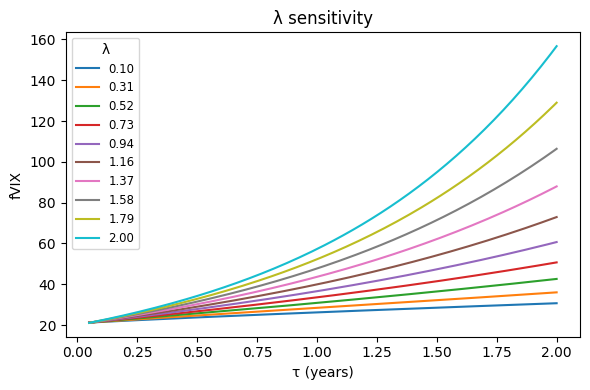

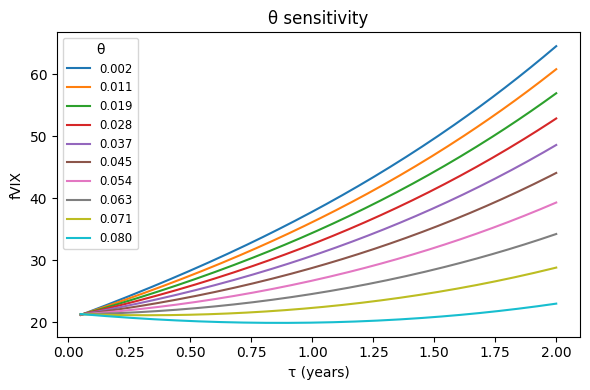

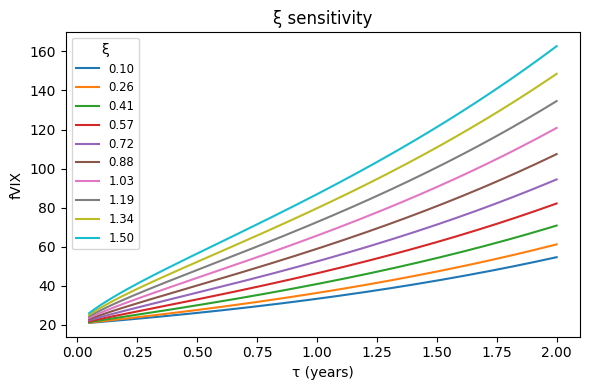

In [23]:
# Baseline parameters
v_t         = 0.044
lambda_base = 1.0
theta_base  = 0.004
xi_base     = 0.30
taus        = np.linspace(0.05, 2.0, 150)

# VIX lambda sensitivity
plt.figure(figsize=(6, 4))
for lambda_ in np.linspace(0.1, 2.0, 10):
    prices = [vix_future_price(t, v_t, lambda_, theta_base, xi_base) for t in taus]
    plt.plot(taus, prices, label=f"{lambda_:.2f}")
plt.title("λ sensitivity")
plt.xlabel("τ (years)")
plt.ylabel("fVIX")
plt.legend(title="λ", fontsize="small")
plt.tight_layout()
plt.savefig("vix_lambda_sensitivity.png")
plt.show()

# VIX theta sensitivity
plt.figure(figsize=(6, 4))
for theta in np.linspace(0.002, 0.08, 10):
    prices = [vix_future_price(t, v_t, lambda_base, theta, xi_base) for t in taus]
    plt.plot(taus, prices, label=f"{theta:.3f}")
plt.title("θ sensitivity")
plt.xlabel("τ (years)")
plt.ylabel("fVIX")
plt.legend(title="θ", fontsize="small")
plt.tight_layout()
plt.savefig("vix_theta_sensitivity.png")
plt.show()

# VIX xi sensitivity
plt.figure(figsize=(6, 4))
for xi in np.linspace(0.1, 1.5, 10):
    prices = [vix_future_price(t, v_t, lambda_base, theta_base, xi) for t in taus]
    plt.plot(taus, prices, label=f"{xi:.2f}")
plt.title("ξ sensitivity")
plt.xlabel("τ (years)")
plt.ylabel("fVIX")
plt.legend(title="ξ", fontsize="small")
plt.tight_layout()
plt.savefig("vix_xi_sensitivity.png")
plt.show()

## 3.7 - Numerical Computation of Variance Futures Prices

In [24]:
def variance_future_price(tau, accrued_var, v_t, lambda_, theta, elapsed):
    """
    Compute the price of a variance future contract using the Andersen-Broadie formula.
    
    Parameters
    ----------
    tau : float > 0
        Time to maturity in years.
    accrued_var : float > 0
        Accrued variance (the variance of the underlying asset over the elapsed time).
    v_t : float > 0
        Current variance of the underlying asset.
    lambda_ : float > 0
        Mean-reversion speed (λ).
    theta : float > 0
        Long-run variance (θ).
    elapsed : float > 0
        Elapsed time in years since the start of the contract.

    Returns
    -------
    float
        The price of the variance future contract.
    """
    b = (1.0 - np.exp(-lambda_ * tau)) / lambda_
    a = theta * (tau - b)
    numerator = accrued_var +  10_000.0 * (a + b*v_t)

    return numerator / elapsed

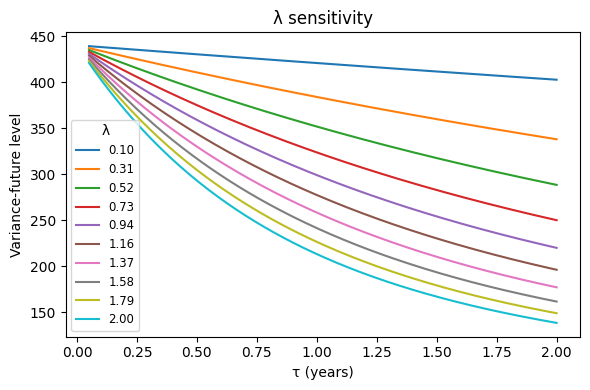

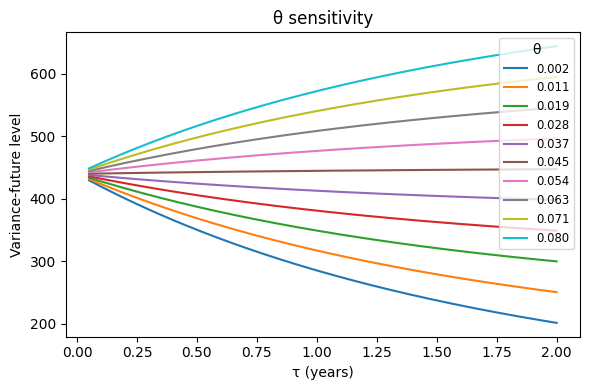

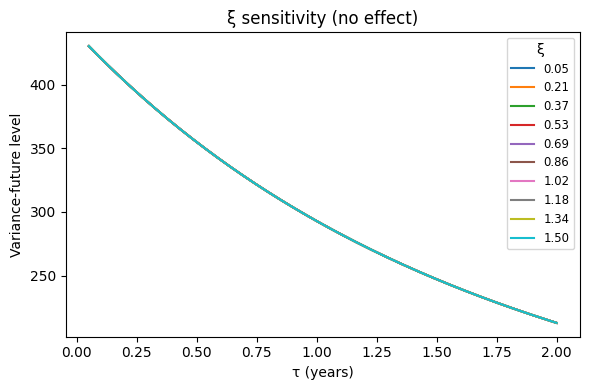

In [ ]:
# Baseline parameters for variance future pricing
v_t_base   = 0.044
accrued_var = 0
lambda_base = 1.0
theta_base  = 0.004
xi_base     = 0.30
taus        = np.linspace(0.05, 2.0, 150)

# VAR Lambda sensitivity
plt.figure(figsize=(6, 4))
for lambda_ in np.linspace(0.1, 2.0, 10):
    prices = [variance_future_price(t, accrued_var, v_t_base,
                                    lambda_, theta_base, t)
              for t in taus]
    plt.plot(taus, prices, label=f"{lambda_:.2f}")
plt.title("λ sensitivity")
plt.xlabel("τ (years)")
plt.ylabel("Variance-future level")
plt.legend(title="λ", fontsize="small")
plt.tight_layout()
plt.savefig("var_lambda_sensitivity.png")
plt.show()

# VAR Theta sensitivity figure
plt.figure(figsize=(6, 4))
for theta in np.linspace(0.002, 0.08, 10):
    prices = [variance_future_price(t, accrued_var, v_t_base,
                                    lambda_base, theta, t)
              for t in taus]
    plt.plot(taus, prices, label=f"{theta:.3f}")
plt.title("θ sensitivity")
plt.xlabel("τ (years)")
plt.ylabel("Variance-future level")
plt.legend(title="θ", fontsize="small")
plt.tight_layout()
plt.savefig("var_theta_sensitivity.png")
plt.show()

# VAR Xi sensitivity
plt.figure(figsize=(6, 4))
xi_values = np.linspace(0.05, 1.5, 10)
for xi in xi_values:
    prices = [variance_future_price(t, accrued_var, v_t_base,
                                    lambda_base, theta_base, t)
              for t in taus]
    plt.plot(taus, prices, label=f"{xi:.2f}")
plt.title("ξ sensitivity (no effect)")
plt.xlabel("τ (years)")
plt.ylabel("Variance-future level")
plt.legend(title="ξ", fontsize="small")
plt.tight_layout()
plt.savefig("var_xi_sensitivity.png")
plt.show()

## 3.8 - Calibration of Volatility Model Parameters

In [9]:
# Load the data from the Excel file
df = pd.ExcelFile("Fin404-2025-VIXNCO-Data.xlsx")
var = df.parse(sheet_name=0, skiprows=4, nrows=8, header=0, usecols=range(1,8), engine="openpyxl")
vix = df.parse(sheet_name=0, skiprows=15,header=0,  usecols=range(1,5), nrows=9, engine="openpyxl")

# Convert to annualized with trading days
var['tau'] = var['Remaining'] / 252
var["T_t0"] = var["Total"] / 252

# Annualize accrued variance and put it in the right format for our function (Divide by T - t_0)
var["accr"] = var["ACCRUED (annualize)"] * var["Elapsed "] / 252
vix['tau'] = vix['Days to maturity'] / 252

FileNotFoundError: [Errno 2] No such file or directory: 'Fin404-2025-VIXNCO-Data.xlsx'

In [10]:
def objective(params):
    """
    params = (v_t, lambda_, theta, xi)
    returns scalar RMSE, the modeling error of future vix and future var for the given params
    """

    v_t, lambda_, theta, xi = params

    future_var = []
    future_vix = []
    
    #Compute the var prediction
    for accrued_variance, tau, settlement, elapsed in zip(
        var["accr"],
        var['tau'].values,
        var['SETTLEMENT'].values,
        var['T_t0'].values
    ): 
        model_price = variance_future_price(
            tau=tau,
             v_t=v_t, 
              accrued_var=accrued_variance,
            theta=theta,
             lambda_=lambda_,
            elapsed=elapsed
        )
        error = model_price - settlement
        future_var.append(error)

    # Compute the vix prediction
    for tau, settlement in zip(
        vix['tau'].values,
        vix['SETTLEMENT'].values
    ):
        model_price = vix_future_price(
            tau=tau,
            v_t=v_t, lambda_=lambda_,
        theta=theta, xi=xi
        )
        error = model_price - settlement
        future_vix.append(error)

    model_error = np.concatenate([future_var, future_vix])
    rmse = np.sqrt(np.mean(np.square(model_error)))
    
    return rmse

In [8]:
from scipy.optimize import minimize
import numpy as np

# Define multiple guesses for [v_t, lambda_, theta, xi]
initial_guesses = [
    [0.05, 1, 0.05, 0.05],
    [0.05, 1.4, 0.05, 0.05],
    [0.1,  0.5, 0.1,  0.2],
    [0.01, 2.0, 0.02, 0.5],
    [0.2,  0.3, 0.15, 0.1],
    [0.03, 1.5, 0.04, 0.8]
]

# Define the bounds for our parameters, it should be non negative
bnds = [(1e-6, None)] * 4

# Store all results
results = []

# Loop over initial guesses
for i, x0 in enumerate(initial_guesses):
    print(f"\n--- Trying initial guess set {i+1}: {x0} ---")
    res = minimize(
        objective,
        np.array(x0),
        method="L-BFGS-B",
        bounds=bnds,
        options={
            'disp': False,
            "finite_diff_rel_step": 1e-4,
            "maxiter": 1000
        }
    )
    results.append({
        "initial_guess_set": i + 1,
        "x0": x0,
        "RMSE": res.fun,
        "params": res.x
    })

# Sort results by RMSE
results = sorted(results, key=lambda r: r["RMSE"])

best = results[0]
print(f'The best params are {best['params']}')
print(f'The best RMSE is : {best['RMSE']}')


--- Trying initial guess set 1: [0.05, 1, 0.05, 0.05] ---

--- Trying initial guess set 2: [0.05, 1.4, 0.05, 0.05] ---

--- Trying initial guess set 3: [0.1, 0.5, 0.1, 0.2] ---


/var/folders/rh/d_gcmf2528dg0s20gp43__bm0000gn/T/ipykernel_54363/2691672053.py:108: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, error_est = quad(
/var/folders/rh/d_gcmf2528dg0s20gp43__bm0000gn/T/ipykernel_54363/2691672053.py:108: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral, error_est = quad(



--- Trying initial guess set 4: [0.01, 2.0, 0.02, 0.5] ---

--- Trying initial guess set 5: [0.2, 0.3, 0.15, 0.1] ---


/var/folders/rh/d_gcmf2528dg0s20gp43__bm0000gn/T/ipykernel_54363/2691672053.py:106: RuntimeWarning: overflow encountered in exp
  return (1.0 - np.exp(-l_of_s(s))) / s**1.5
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0



--- Trying initial guess set 6: [0.03, 1.5, 0.04, 0.8] ---
The best params are [0.04982917 1.29955498 0.07054531 0.25976973]
The best RMSE is : 0.15759520914267203


In [9]:
v_t, lambda_, theta, xi = best['params']

future_var = []
future_vix = []
param_log = []  # To store the parameters used in each iteration

# Compute the future variance prices using the best parameters
for accrued_variance, tau, elapsed in zip(
    var['accr'],
    var['tau'].values,
    var['T_t0'].values
):
    model_price = variance_future_price(
        tau=tau,
        v_t=v_t,
        accrued_var=accrued_variance,
        lambda_=lambda_,
        theta=theta,
        elapsed=elapsed
    )

    future_var.append(model_price)

# Compute the future VIX prices using the best parameters
for tau, settlement in zip(
    vix['tau'].values,
    vix['SETTLEMENT'].values
):
    model_price = vix_future_price(
        tau=tau,
        v_t=v_t, lambda_=lambda_,
    theta=theta, xi=xi
    )

    future_vix.append(model_price)

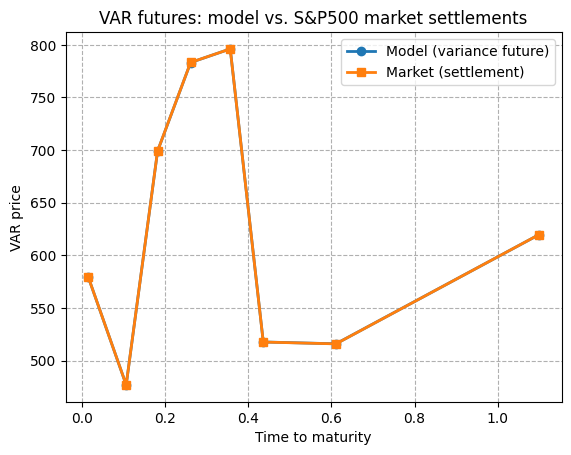

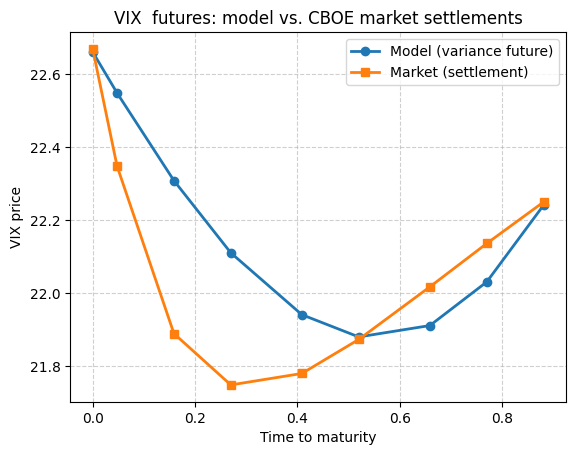

In [10]:
# Plotting the calculated future prices against the market settlements
plt.plot(var['tau'], future_var,
        linewidth=2, marker="o", label="Model (variance future)")
plt.plot(var['tau'], var["SETTLEMENT"],
        linewidth=2, marker="s", label="Market (settlement)")


plt.xlabel("Time to maturity")
plt.ylabel("VAR price")
plt.title("VAR futures: model vs. S&P500 market settlements")

plt.grid(True, linestyle="--", alpha=1)
plt.legend()

plt.savefig("var_fitted.png")
plt.show()

# Plotting the calculated future VIX prices against the market settlements
plt.plot(vix['tau'], future_vix,
        linewidth=2, marker="o", label="Model (variance future)")
plt.plot(vix['tau'], vix["SETTLEMENT"],
        linewidth=2, marker="s", label="Market (settlement)")


plt.xlabel("Time to maturity")
plt.ylabel("VIX price")
plt.title("VIX  futures: model vs. CBOE market settlements")


plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.savefig("vix_fitted.png")

plt.show()